In [1]:
!nvidia-smi

Sat Dec  5 09:45:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 23.1MB/s 


In [3]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import datetime
import tensorflow_datasets as tfds

%load_ext tensorboard

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow_datasets as tfds
datasets, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True, try_gcs=True, split=['train','test'])

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMO8OPE/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMO8OPE/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [7]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
fm_train, fm_test = datasets[0], datasets[1]
fm_val = fm_test.take(3000)
fm_test = fm_test.skip(3000)

In [9]:
print(fm_train)

<PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


In [10]:
len(list(fm_train))

60000

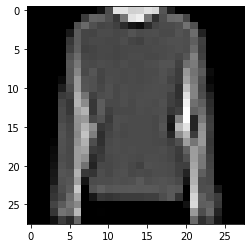

Label: 2
Category: Pullover


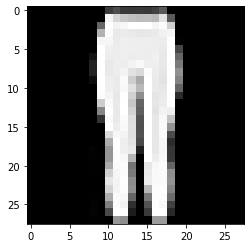

Label: 1
Category: Trouser


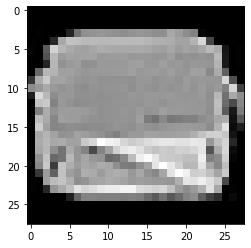

Label: 8
Category: Bag


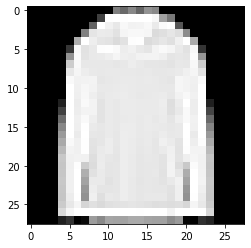

Label: 4
Category: Coat


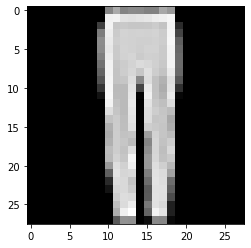

Label: 1
Category: Trouser


In [12]:
import numpy as np
import matplotlib.pyplot as plt
for fm_sample in fm_train.take(5):  
  image, label = fm_sample[0], fm_sample[1]

  plt.figure()
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
  plt.show()
  print("Label: %d" % label.numpy())
  print("Category: %s" % info.features["label"].names[label.numpy()])

In [13]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return image, label

In [14]:
def get_dataset(batch_size=64):
  train_dataset_scaled = fm_train.map(scale).shuffle(60000).batch(batch_size)
  test_dataset_scaled = fm_test.map(scale).batch(batch_size)
  val_dataset_scaled = fm_val.map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [15]:
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.MaxPooling2D(),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(10, activation='softmax')])

In [16]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(128, 5, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model